In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from dateutil import parser

raw_data = pd.read_csv('2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv')

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

raw_data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
306,"Jan 10, 2020",258.19,257.86,259.25,256.88,18.85M,0.08%
307,"Jan 09, 2020",257.99,259.40,261.76,257.01,38.33M,-0.45%
308,"Jan 08, 2020",259.15,253.57,259.15,253.03,40.82M,2.07%
309,"Jan 06, 2020",253.90,254.75,254.84,251.40,22.35M,-0.43%
310,"Jan 03, 2020",255.00,255.99,258.19,253.70,35.85M,0.10%


In [9]:
#Prepare data

time_series = [float(i) for i in time_series]
time_series.reverse()

X, y = split_sequence(time_series, 7)

X_train, y_train = X[:244], y[:244]
X_test, y_test = X[245:], y[245:]

In [10]:
#Define LSTM

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
#Fit model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

model.fit(X_train, y_train, epochs=200, verbose=0)

In [12]:
#Test model

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred.reshape((y_pred.shape[1], y_pred.shape[0]))
y_pred = y_pred[0]

mean_absolute_error(y_test, y_pred)

4.883104661844542

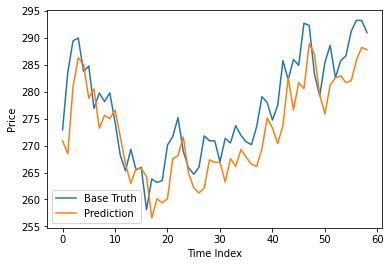

In [13]:
#Plot model prediction

plt.plot(y_test, label='Base Truth')
plt.plot(y_pred, label='Prediction')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [71]:
#Convert date to datetime.

reformatted_dt = []
for date in raw_data.Date:
    reformatted_dt.append(parser.parse(date))
raw_data['Date'] = reformatted_dt

years = []
for date in raw_data.Date:
    years.append(date.year)
raw_data['Year'] = years

In [72]:
#Invert dataset

raw_data = raw_data[::-1].reset_index(drop=True)

#Calculate SMAs

sma_30 = raw_data.Price.rolling(30).mean()
raw_data['monthly_sma'] = sma_30

#Calculate StDs

std_30 = raw_data.Price.rolling(30).std()
raw_data['monthly_std'] = std_30

#Calculat BBs

ubb_30 = []
for i in range(len(raw_data)):
    ubb_30.append(raw_data.monthly_sma[i] + raw_data.monthly_std[i] * 2)
raw_data['monthly_UBB'] = ubb_30

lbb_30 = []
for i in range(len(raw_data)):
    lbb_30.append(raw_data.monthly_sma[i] - raw_data.monthly_std[i] * 2)
raw_data['monthly_LBB'] = lbb_30

raw_data

,Date,Price,Open,High,Low,Vol.,Change %,Year,monthly_sma,monthly_std,monthly_UBB,monthly_LBB
0,2020-01-03,255.00,255.99,258.19,253.70,35.85M,0.10%,2020,NaN,NaN,NaN,NaN
1,2020-01-06,253.90,254.75,254.84,251.40,22.35M,-0.43%,2020,NaN,NaN,NaN,NaN
2,2020-01-08,259.15,253.57,259.15,253.03,40.82M,2.07%,2020,NaN,NaN,NaN,NaN
3,2020-01-09,257.99,259.40,261.76,257.01,38.33M,-0.45%,2020,NaN,NaN,NaN,NaN
4,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.08%,2020,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
306,2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%,2021,277.946000,7.993083,293.932165,261.959835
307,2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%,2021,278.830000,7.943965,294.717929,262.942071
308,2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%,2021,279.740000,7.987101,295.714202,263.765798
309,2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%,2021,280.454667,8.209188,296.873043,264.036290


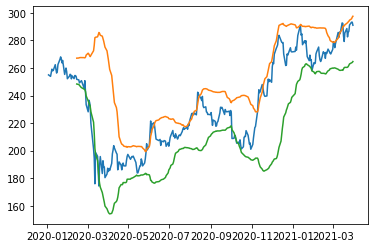

In [73]:
#Plot

plt.plot(raw_data.Date, raw_data.Price)
plt.plot(raw_data.Date, raw_data.monthly_UBB)
plt.plot(raw_data.Date, raw_data.monthly_LBB)

In [74]:
#Reset index

raw_data = raw_data.reset_index()

In [97]:
#Use plot to make predictions
#2020: Training set
#2021: Test set

train = np.array(raw_data.Price[raw_data.Year == 2020])
test = np.array(raw_data.Price[raw_data.Year == 2021])

X_train, y_train = split_sequence(train, 7)

In [98]:
#Define LSTM

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [99]:
#Fit model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

model.fit(X_train, y_train, epochs=200, verbose=0)

In [100]:
#Test model

X_test, y_test = split_sequence(test, 7)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred.reshape((y_pred.shape[1], y_pred.shape[0]))
y_pred = y_pred[0]

mean_absolute_error(y_test, y_pred)

4.142095291702839

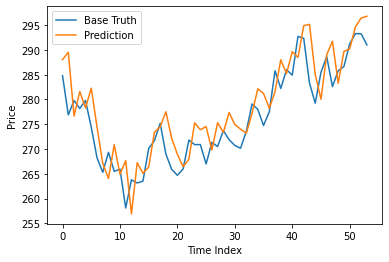

In [101]:
#Plot model prediction

plt.plot(y_test, label='Base Truth')
plt.plot(y_pred, label='Prediction')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()

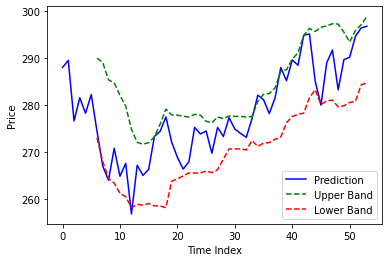

In [135]:
#Calculate and plot Bollinger Bands

def get_bands(sequence, window):
    sequence = pd.Series(sequence)
    sma = sequence.rolling(window).mean()
    std = sequence.rolling(window).std()
    sma, std = np.array(sma), np.array(std)
    ub = sma + (std * 1.5)
    lb = sma - (std * 1.5)
    return ub, lb

ub, lb = get_bands(y_pred, 7)

plt.plot(y_pred, label='Prediction', color='blue')
plt.plot(ub, label='Upper Band', color='green', linestyle='--')
plt.plot(lb, label='Lower Band', color='red', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [140]:
#Use BB for buy/sell strategy

order = []
for i in range(len(y_pred)):
    if y_pred[i] >= ub[i]:
        order.append(-1)
    elif y_pred[i] <= lb[i]:
        order.append(1)
    else:
        order.append(0)

In [146]:
#Run strategy

stocks = [10]
investment = [y_pred[0]*stocks[0]] 

for i in range(len(y_pred)):
    stocks.append(stocks[i] + order[i])
    investment.append(stocks[i+1] * y_pred[i])
    
print(stocks, investment)

[10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10] [2880.4483032226562, 2880.4483032226562, 2895.338134765625, 2766.7047119140625, 2816.0546875, 2783.0538940429688, 2822.8067016601562, 2744.8818969726562, 2403.7673950195312, 2112.474365234375, 2166.869140625, 2119.2529296875, 2141.338134765625, 1798.3809204101562, 1870.7128295898438, 1855.6722717285156, 1864.633544921875, 2187.037109375, 2195.8203125, 2220.271728515625, 2177.466796875, 2151.5771484375, 2131.472412109375, 2143.723876953125, 2202.266357421875, 2191.21630859375, 2196.292236328125, 2158.450927734375, 2202.50146484375, 2186.900390625, 2218.88671875, 2199.60107421875, 2192.1123046875, 2185.509521484375, 2217.6220703125, 2539.3419799804688, 2530.8270263671875, 2504.111572265625, 2533.8510131835938, 2880.137939453125, 2852.24853515625, 2896.329345703125, 2885.0323486328125, 3243.94323730468

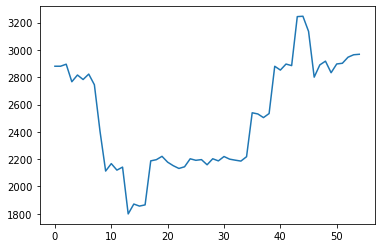

In [147]:
plt.plot(investment)

In [149]:
roi = 100 * (investment[-1]/investment[0])
print(roi)

103.03877046862513
